In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import seaborn as sns
import pymc3 as pm
%matplotlib inline

In [337]:
df_med_county = pd.read_csv('data/medicare_county_level/medicare_county_all.csv', index_col=0)

In [338]:
df_med_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25528 entries, 0 to 3190
Columns: 244 entries, State to year
dtypes: int64(1), object(243)
memory usage: 47.7+ MB


In [339]:
df_med_county.head()

,State,County,State and County FIPS Code,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,...,PQI11 Bacterial Pneumonia Admission Rate (age 65-74),PQI11 Bacterial Pneumonia Admission Rate (age 75+),PQI12 UTI Admission Rate (age < 65),PQI12 UTI Admission Rate (age 65-74),PQI12 UTI Admission Rate (age 75+),PQI15 Asthma in Younger Adults Admission Rate (age < 40),PQI16 Lower Extremity Amputation Admission Rate (age < 65),PQI16 Lower Extremity Amputation Admission Rate (age 65-74),PQI16 Lower Extremity Amputation Admission Rate (age 75+),year
0,National,NATIONAL TOTAL,.,42506654,33030525,9476129,22.29,72,56.06,43.94,...,804,2103,433,317,1228,416,114,45,52,2007
1,AK,STATE TOTAL,.,53956,53434,522,0.97,70,50.88,49.12,...,836,1912,*,166,860,*,122,*,*,2007
2,AK,ANCHORAGE,2020,21981,21752,229,1.04,69,53.29,46.71,...,.,.,.,.,.,.,.,.,.,2007
3,AK,BETHEL,2050,661,661,0,0,71,48.87,51.13,...,.,.,.,.,.,.,.,.,.,2007
4,AK,BRISTOL BAY,2060,*,630,*,*,68,49.37,50.63,...,.,.,.,.,.,.,.,.,.,2007


In [340]:
df_med_county.iloc[:,2:] = df_med_county.iloc[:,2:].apply(pd.to_numeric, errors='coerce', axis=1)

In [341]:
df_med_county.head()

,State,County,State and County FIPS Code,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,...,PQI11 Bacterial Pneumonia Admission Rate (age 65-74),PQI11 Bacterial Pneumonia Admission Rate (age 75+),PQI12 UTI Admission Rate (age < 65),PQI12 UTI Admission Rate (age 65-74),PQI12 UTI Admission Rate (age 75+),PQI15 Asthma in Younger Adults Admission Rate (age < 40),PQI16 Lower Extremity Amputation Admission Rate (age < 65),PQI16 Lower Extremity Amputation Admission Rate (age 65-74),PQI16 Lower Extremity Amputation Admission Rate (age 75+),year
0,National,NATIONAL TOTAL,NaN,42506654.0,33030525.0,9476129.0,22.29,72.0,56.06,43.94,...,804.0,2103.0,433.0,317.0,1228.0,416.0,114.0,45.0,52.0,2007.0
1,AK,STATE TOTAL,NaN,53956.0,53434.0,522.0,0.97,70.0,50.88,49.12,...,836.0,1912.0,NaN,166.0,860.0,NaN,122.0,NaN,NaN,2007.0
2,AK,ANCHORAGE,2020.0,21981.0,21752.0,229.0,1.04,69.0,53.29,46.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
3,AK,BETHEL,2050.0,661.0,661.0,0.0,0.00,71.0,48.87,51.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
4,AK,BRISTOL BAY,2060.0,NaN,630.0,NaN,NaN,68.0,49.37,50.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0


In [342]:
df_med_county['Cost_per_Beneficiary'] = df_med_county['Total Actual Costs']/df_med_county['Beneficiaries with Part A and Part B']

In [343]:
state = df_med_county['State']
county = df_med_county['County']
year = df_med_county['year']
countyid = df_med_county['State and County FIPS Code']

#drop columns that are majority Nan
nullrate = df_med_county.isnull().sum()/df_med_county.shape[0]
mask = nullrate < 0.2
cols_tokeep_null = nullrate[mask]
df_med_county = df_med_county.filter(list(cols_tokeep_null.index))
cols_tokeep_null

State                                                               0.000000
County                                                              0.000000
State and County FIPS Code                                          0.017236
Beneficiaries with Part A and Part B                                0.018372
FFS Beneficiaries                                                   0.001254
MA Beneficiaries                                                    0.018372
MA Participation Rate                                               0.018372
Average Age                                                         0.001254
Percent Female                                                      0.001880
Percent Male                                                        0.001880
Percent Eligible for Medicaid                                       0.008187
Average HCC Score                                                   0.001254
Total Actual Costs                                                  0.001567

In [344]:
correlation_matrix = df_med_county.corr()
df_med_county.columns

Index(['State', 'County', 'State and County FIPS Code',
       'Beneficiaries with Part A and Part B', 'FFS Beneficiaries',
       'MA Beneficiaries', 'MA Participation Rate', 'Average Age',
       'Percent Female', 'Percent Male',
       ...
       'Ambulance Per User Standardized Costs', '# Ambulance Users',
       '% of Beneficiaries Using Ambulance',
       'Ambulance Events Per 1000 Beneficiaries',
       'Number of Acute Hospital Readmissions', 'Hospital Readmission Rate',
       'Emergency Department Visits',
       'Emergency Department Visits per 1000 Beneficiaries', 'year',
       'Cost_per_Beneficiary'],
      dtype='object', length=181)

In [345]:
correlation_costperben = correlation_matrix.iloc[:,-1]

In [346]:
correlation_costperben.sort_values()

MA Participation Rate                                              -0.674011
Procedures Standardized Costs as % of Total Standardized Costs     -0.298698
Procedures Actual Costs as % of Total Actual Costs                 -0.278640
Percent Male                                                       -0.238413
E&M Standardized Costs as % of Total Standardized Costs            -0.190674
OP Standardized Costs as % of Total Standardized Costs             -0.180747
E&M Actual Costs as % of Total Actual Costs                        -0.176828
DME Standardized Costs as % of Total Standardized Costs            -0.156284
IP Standardized Costs as % of Total Standardized Costs             -0.149336
DME Actual Costs as % of Total Actual Costs                        -0.135886
OP Actual Costs as % of Total Actual Costs                         -0.124227
IP Actual Costs as % of Total Actual Costs                         -0.113450
Part B Drugs Actual Costs as % of Total Actual Costs               -0.107836

In [347]:
#Keep anything with greater than 0.4 correlation coef
mask = (correlation_costperben > 0.3) | (correlation_costperben < -0.3)
fields_to_keep = correlation_costperben[mask]

In [348]:
colnames = fields_to_keep.index

In [349]:
df_med_county = df_med_county.filter(list(colnames))

In [350]:
df_med_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25528 entries, 0 to 3190
Data columns (total 27 columns):
MA Participation Rate                                          25059 non-null float64
Average HCC Score                                              25496 non-null float64
Actual Per Capita Costs                                        25488 non-null float64
Standardized Per Capita Costs                                  25488 non-null float64
Standardized Risk-Adjusted Per Capita Costs                    25488 non-null float64
IP Per Capita Actual Costs                                     25437 non-null float64
IP Per Capita Standardized Costs                               25437 non-null float64
% of Beneficiaries Using IP                                    25437 non-null float64
IP Covered Stays Per 1000 Beneficiaries                        25437 non-null float64
IP Covered Days Per 1000 Beneficiaries                         25437 non-null float64
PAC: SNF Per Capita Actual Costs

In [351]:
df_med_county.columns



Index(['MA Participation Rate', 'Average HCC Score', 'Actual Per Capita Costs',
       'Standardized Per Capita Costs',
       'Standardized Risk-Adjusted Per Capita Costs',
       'IP Per Capita Actual Costs', 'IP Per Capita Standardized Costs',
       '% of Beneficiaries Using IP',
       'IP Covered Stays Per 1000 Beneficiaries',
       'IP Covered Days Per 1000 Beneficiaries',
       'PAC: SNF Per Capita Actual Costs',
       'PAC: SNF Per Capita Standardized Costs',
       'PAC: SNF Per User Standardized Costs',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Days Per 1000 Beneficiaries',
       'PAC: HH Actual Costs as % of Total Actual Costs',
       'PAC: HH Per Capita Actual Costs', 'PAC: HH Per User Actual Costs',
       'PAC: HH Standardized Costs as % of Total Standardized Costs',
       'PAC: HH Per Capita Standardized Costs',
       'PAC: HH Per User Standardized Costs',
       '% of Beneficiaries Using PAC: HH',
       'PAC: HH Episodes P

In [352]:
df_med_county['State'] = state
df_med_county['County'] = county
df_med_county['year'] = year
df_med_county['CountyID'] = countyid

df_med_county.year = df_med_county.year.astype(int)

In [353]:
df_med_county.head()

,MA Participation Rate,Average HCC Score,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Per Capita Actual Costs,IP Per Capita Standardized Costs,% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,...,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Imaging Events Per 1000 Beneficiaries,% of Beneficiaries Using DME,Cost_per_Beneficiary,State,County,year,CountyID
0,22.29,1.0000,8271.85,7947.16,8218.21,3047.80,2593.17,0.2050,338.0,1901.0,...,0.0875,164.0,3246.0,4087.0,0.2860,6427.779999,National,NATIONAL TOTAL,2007,NaN
1,0.97,0.8530,6856.01,5453.02,6550.84,3210.91,2171.97,0.1647,247.0,1367.0,...,0.0402,61.0,950.0,3150.0,0.2167,6789.682568,AK,STATE TOTAL,2007,NaN
2,1.04,0.8743,6688.90,5401.74,6233.46,3156.64,2169.29,0.1609,244.0,1425.0,...,0.0444,64.0,1016.0,3747.0,0.2267,6619.210000,AK,ANCHORAGE,2007,2020.0
3,0.00,0.8318,7563.27,4185.52,5138.40,4080.24,2166.93,0.2088,316.0,1637.0,...,NaN,NaN,NaN,1030.0,0.1180,7563.268306,AK,BETHEL,2007,2050.0
4,NaN,0.7691,5874.40,4712.96,6982.94,3158.89,2104.14,0.1429,206.0,1129.0,...,0.0286,37.0,417.0,2987.0,0.1952,NaN,AK,BRISTOL BAY,2007,2060.0


In [354]:
corr = df_med_county.corr()

In [355]:
corr

,MA Participation Rate,Average HCC Score,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Per Capita Actual Costs,IP Per Capita Standardized Costs,% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,...,PAC: HH Per Capita Standardized Costs,PAC: HH Per User Standardized Costs,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Imaging Events Per 1000 Beneficiaries,% of Beneficiaries Using DME,Cost_per_Beneficiary,year,CountyID
MA Participation Rate,1.000000,0.178361,0.020253,-0.025009,-0.187264,0.017162,-0.071622,-0.239035,-0.179735,-0.089958,...,-0.046659,-0.055662,0.007793,-0.068555,-0.060726,0.020171,-0.211743,-0.674011,2.326145e-01,5.258150e-02
Average HCC Score,0.178361,1.000000,0.634212,0.674651,0.099065,0.542457,0.630209,0.486655,0.566463,0.670603,...,0.454030,0.381614,0.539107,0.436955,0.417827,0.639133,0.388985,0.344480,2.936865e-03,1.506319e-02
Actual Per Capita Costs,0.020253,0.634212,1.000000,0.894578,0.652651,0.761999,0.674533,0.421616,0.490024,0.546785,...,0.564117,0.473519,0.592657,0.546183,0.531648,0.542077,0.221134,0.714392,2.703928e-01,-1.385648e-02
Standardized Per Capita Costs,-0.025009,0.674651,0.894578,1.000000,0.750408,0.549206,0.751859,0.564314,0.615365,0.629095,...,0.684686,0.620495,0.693919,0.666446,0.639989,0.656831,0.444728,0.680423,1.757485e-01,1.329784e-02
Standardized Risk-Adjusted Per Capita Costs,-0.187264,0.099065,0.652651,0.750408,1.000000,0.289565,0.485604,0.363912,0.336110,0.261087,...,0.447414,0.427854,0.413608,0.437720,0.418378,0.361799,0.287174,0.622953,2.629979e-01,-1.367072e-02
IP Per Capita Actual Costs,0.017162,0.542457,0.761999,0.549206,0.289565,1.000000,0.770592,0.495359,0.575855,0.644198,...,0.229894,0.152549,0.292582,0.222795,0.216076,0.404190,0.107382,0.541097,2.994437e-02,-3.976997e-02
IP Per Capita Standardized Costs,-0.071622,0.630209,0.674533,0.751859,0.485604,0.770592,1.000000,0.790995,0.846354,0.833419,...,0.368295,0.330595,0.409119,0.359325,0.340819,0.600276,0.430898,0.544874,-1.228654e-01,-3.219189e-02
% of Beneficiaries Using IP,-0.239035,0.486655,0.421616,0.564314,0.363912,0.495359,0.790995,1.000000,0.958452,0.826546,...,0.311988,0.267619,0.330029,0.315853,0.307665,0.493983,0.505994,0.471304,-4.349590e-01,-3.859776e-02
IP Covered Stays Per 1000 Beneficiaries,-0.179735,0.566463,0.490024,0.615365,0.336110,0.575855,0.846354,0.958452,1.000000,0.894982,...,0.367474,0.325644,0.393403,0.367421,0.352975,0.543515,0.503924,0.482208,-3.772283e-01,-3.665668e-02
IP Covered Days Per 1000 Beneficiaries,-0.089958,0.670603,0.546785,0.629095,0.261087,0.644198,0.833419,0.826546,0.894982,1.000000,...,0.404788,0.360579,0.455102,0.397315,0.383266,0.610813,0.419732,0.457380,-3.310925e-01,-3.762475e-02


## Counties within States are different

Text(0,0.5,'Avg Cost/Beneficiary per County')

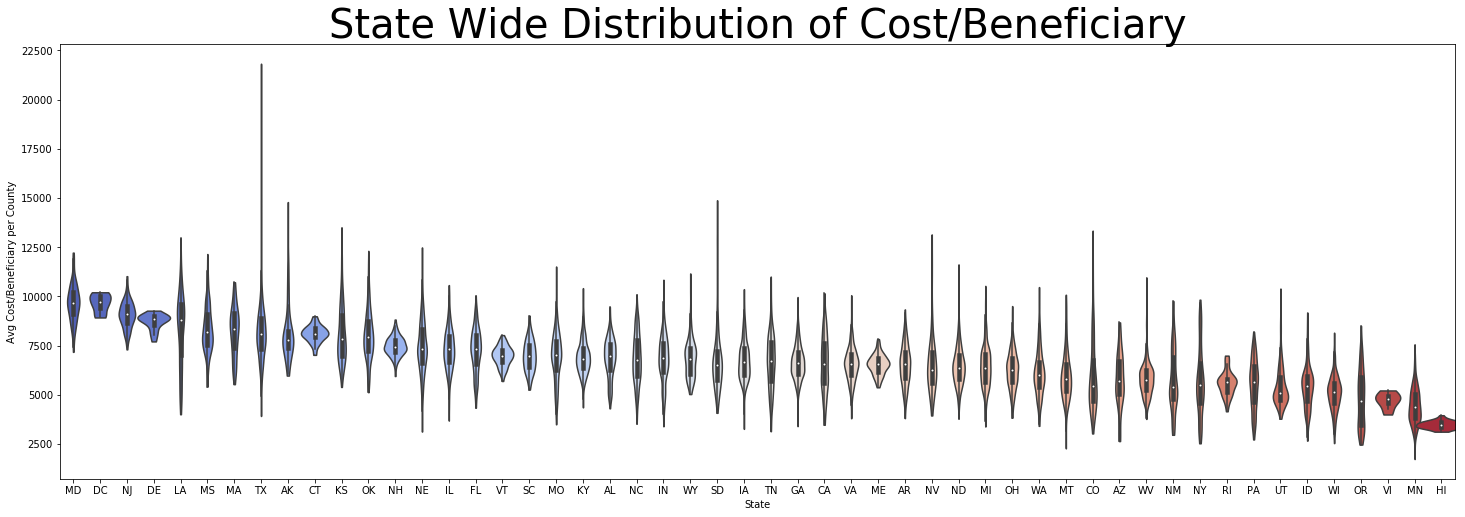

In [356]:
order = df_med_county.groupby('State').mean()['Cost_per_Beneficiary'].sort_values(ascending=False)
order.drop(['National','XX','PR'],inplace = True)

matplotlib.rcParams['figure.figsize'] = [25.0, 8.0]
sns.violinplot(x="State", y="Cost_per_Beneficiary",
        data=df_med_county, order= list(order.index), width = 1.9,palette="coolwarm", cut=0)
plt.title('State Wide Distribution of Cost/Beneficiary', fontsize=40)
plt.ylabel('Avg Cost/Beneficiary per County')

## States are different too

Text(0.5,0,'USA')

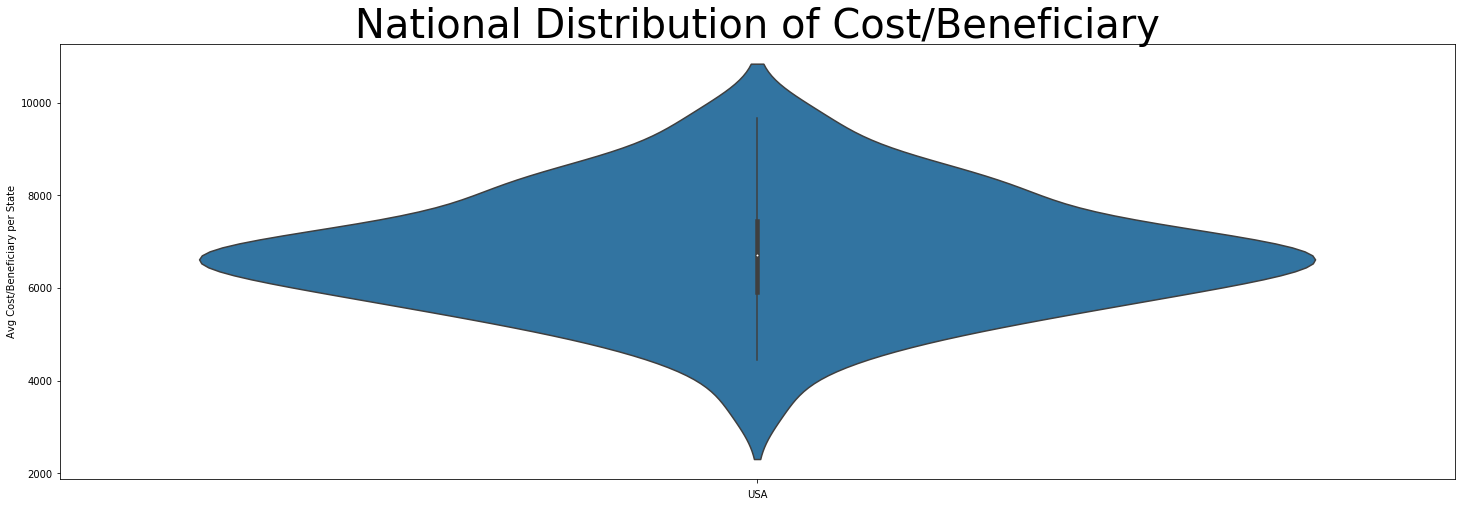

In [357]:
sns.violinplot(order, orient='v')
plt.title('National Distribution of Cost/Beneficiary', fontsize=40)
plt.ylabel('Avg Cost/Beneficiary per State')
plt.xlabel('USA')

## Linear Regression Model

In [358]:
df_med_county.columns


Index(['MA Participation Rate', 'Average HCC Score', 'Actual Per Capita Costs',
       'Standardized Per Capita Costs',
       'Standardized Risk-Adjusted Per Capita Costs',
       'IP Per Capita Actual Costs', 'IP Per Capita Standardized Costs',
       '% of Beneficiaries Using IP',
       'IP Covered Stays Per 1000 Beneficiaries',
       'IP Covered Days Per 1000 Beneficiaries',
       'PAC: SNF Per Capita Actual Costs',
       'PAC: SNF Per Capita Standardized Costs',
       'PAC: SNF Per User Standardized Costs',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Days Per 1000 Beneficiaries',
       'PAC: HH Actual Costs as % of Total Actual Costs',
       'PAC: HH Per Capita Actual Costs', 'PAC: HH Per User Actual Costs',
       'PAC: HH Standardized Costs as % of Total Standardized Costs',
       'PAC: HH Per Capita Standardized Costs',
       'PAC: HH Per User Standardized Costs',
       '% of Beneficiaries Using PAC: HH',
       'PAC: HH Episodes P

In [359]:
evetsper1000cols = ['MA Participation Rate', 'Average HCC Score',
       'IP Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: HH Visits Per 1000 Beneficiaries',
       'Imaging Events Per 1000 Beneficiaries', 
        'State', 'County', 'year','CountyID',
        'Cost_per_Beneficiary']
df_1000cols = df_med_county.filter(evetsper1000cols)

In [360]:
df_1000cols.dropna(inplace = True)

In [361]:
unique_county = df_1000cols.CountyID.unique()

In [366]:
df = df_1000cols.filter(['Cost_per_Beneficiary','CountyID','County','State','year','MA Participation Rate','IP Covered Stays Per 1000 Beneficiaries'])
df.year = preprocessing.scale(df.year)
df['MA_Part_Rate'] = preprocessing.scale(df['MA Participation Rate'])
df['IP_per_1000'] = preprocessing.scale(df['IP Covered Stays Per 1000 Beneficiaries'])

df.drop(['MA Participation Rate', 'IP Covered Stays Per 1000 Beneficiaries'],axis = 1, inplace = True)

counties = df['CountyID'].unique()
n_counties = len(counties)

# Create a lookup table with the index 0 to n_counties matching to unique fips code
cty_lookup = pd.DataFrame({'cty_idx': range(n_counties), 'fips': counties})
# Merge the original dataframe with the cty_lookup table
df = df.merge(cty_lookup, how = 'left', left_on = 'CountyID', right_on = 'fips')
# Drop the fips code
df = df.drop(['CountyID', 'fips'], axis = 1)

#Do the same for States
states = df['State'].unique()
n_states = len(states)

state_lookup = pd.DataFrame({'state_idx': range(n_states), 'state': states})
df = df.merge(state_lookup, how = 'left', left_on = 'State', right_on = 'state')
df = df.drop(['State', 'state'], axis = 1)

df

/Users/Coho/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Cost_per_Beneficiary,County,year,MA_Part_Rate,IP_per_1000,cty_idx,state_idx
0,6619.210000,ANCHORAGE,-1.528287,-1.375269,-0.956933,0,0
1,5980.257930,FAIRBANKS NORTH STAR,-1.528287,-1.398110,-1.503028,1,0
2,7139.319632,JUNEAU,-1.528287,-1.411500,-0.863317,2,0
3,6473.279489,KENAI PENINSULA,-1.528287,-1.357941,-1.019344,3,0
4,6349.885070,MATANUSKA-SUSITNA,-1.528287,-1.346127,-1.097358,4,0
5,6178.872790,AUTAUGA,-1.528287,0.117274,0.322489,5,1
6,6020.460092,BALDWIN,-1.528287,-0.063879,0.400502,6,1
7,6319.637397,BARBOUR,-1.528287,-0.212739,0.790570,7,1
8,6021.787142,BIBB,-1.528287,0.649706,1.102624,8,1
9,5173.668282,BLOUNT,-1.528287,1.134881,0.962200,9,1


To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model separate regressions. For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise ϵ on which we place a Half-Cauchy distribution.


2    True
3    True
4    True
Name: year, dtype: bool

In [369]:
county_names = df.cty_idx.unique()

In [373]:
# Fit a regression for each county
model = LinearRegression()
residuals = []
for county_name in county_names:
    data = df[df == county_name]

    X = data.iloc[:,2:5]
    y = data['Cost_per_Beneficiary']
    X_train = X[X.year != 1.529170]
    X_test = X[X.year == 1.529170]
    y_train = y[X.year != 1.529170]
    y_test = y[X.year == 1.529170]
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    residuals.append(float(y_hat - y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [123]:
print('RMSE for basic linear regression on county level as a funtion of time: ',np.sqrt(np.mean(np.array(residuals)**2)))


RMSE for basic linear regression on county level as a funtion of time:  649.053688555


In [129]:
#Fit one regression for all counties

Xpooled = Non_H_Simple_Data.year
ypooled = Non_H_Simple_Data.Cost_per_Beneficiary
Xpool_train = Xpooled[Xpooled != 2014].values.reshape(-1,1)
Xpool_test = Xpooled[Xpooled == 2014].values.reshape(-1,1)
ypool_train = ypooled[Xpooled != 2014].values.reshape(-1,1)
ypool_test = ypooled[Xpooled == 2014].values.reshape(-1,1)

In [131]:
model.fit(Xpool_train,ypool_train)
y_hats = model.predict(Xpool_test)
residuals = y_hats - ypool_test
print('RMSE for basic linear regression on national level as a funtion of time: ',np.sqrt(np.mean(residuals)**2))

RMSE for basic linear regression on national level as a funtion of time:  392.86785882


In [248]:
# Get a list of unique county fips codes and calculate # unique counties
counties = Non_H_Simple_Data['CountyID'].unique()
n_counties = len(counties)

# Create a lookup table with the index 0 to n_counties matching to unique fips code
cty_lookup = pd.DataFrame({'idx': range(n_counties), 'fips': counties})
# Merge the original dataframe with the cty_lookup table
output = Non_H_Simple_Data.merge(cty_lookup, how = 'left', left_on = 'CountyID', right_on = 'fips')
# Drop the fips code
output = output.drop(['CountyID', 'fips'], axis = 1)

In [171]:
indiv_traces = {}
Train_data = output[output.year != 2014]


#for county_name in county_names:
    # Select subset of data belonging to county
#    c_data = Train_data.ix[Train_data.countyID == county_name]
#    c_data = c_data.reset_index(drop=True)
    

county_idx = output.idx.values

with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.Uniform('sigma_alpha', lower = 0, upper = 5000)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.Uniform('sigma_beta', lower = 0, upper = 5000)

    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(output.idx.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(output.idx.unique()))

    # Model error
    eps = pm.Uniform('sigma_eps', lower = 0, upper = 5000)

    # Expected value
    cost_est = a[county_idx] + b[county_idx] * output.year.values

    # Data likelihood
    y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=output.year)

In [172]:
#takes 30 min
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_eps_interval__, beta, alpha, sigma_beta_interval__, mu_beta, sigma_alpha_interval__, mu_alpha]
100%|██████████| 1000/1000 [27:14<00:00,  1.63s/it]
The acceptance probability does not match the target. It is 0.888820185371, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.610174008357, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparamet

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a415297b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a417cf898>]], dtype=object)

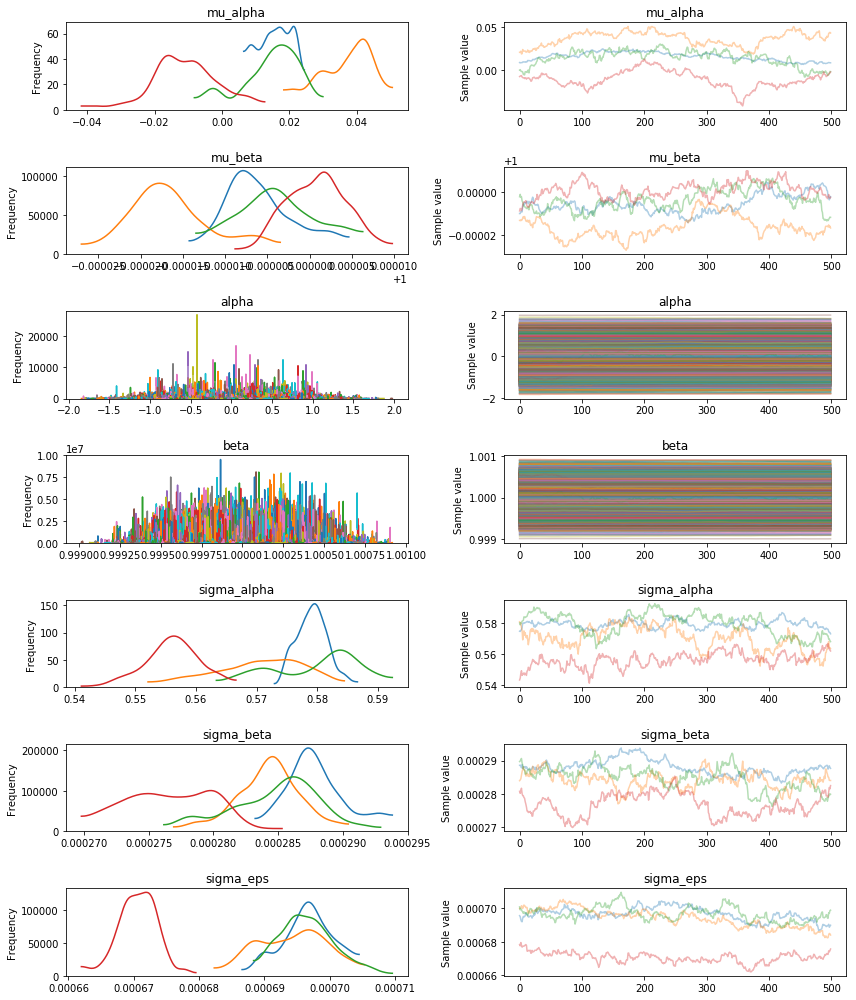

In [173]:
pm.traceplot(hierarchical_trace)

In [174]:
a

alpha

Get trace values for individual parameters

In [215]:
alphas = hierarchical_trace.get_values('alpha', burn = 50)

In [216]:
betas = hierarchical_trace.get_values('beta', burn = 50)

In [217]:
alpha_means = []
for j in range(alphas.shape[1]):
    alpha_means.append(np.mean(alphas[:,j]))


In [218]:
beta_means = []
for j in range(betas.shape[1]):
    beta_means.append(np.mean(betas[:,j]))

In [222]:
alpha_means

3049

In [236]:
y_test = output[output.year == 2014]
y_test.sort_values('idx', inplace = True)
y_test = y_test['Cost_per_Beneficiary']

/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [277]:
y_hats = np.array(alpha_means) + np.array(beta_means) * 2014

In [278]:
len(output.idx.unique())

3049

In [279]:
len(y_hats)

3049

In [280]:
cty_lookup['y_pred'] = y_hats
out2014 = output[output.year == 2014]

In [281]:
# Merge the original dataframe with the cty_lookup table
results = out2014.merge(cty_lookup, how = 'left', left_on = 'idx', right_on = 'idx')


In [282]:
results

,year,Cost_per_Beneficiary,idx,y_pred_x,fips,y_pred_y
0,2014,8227.631675,0,<built-in method transpose of numpy.ndarray ob...,2020.0,2014.000113
1,2014,7395.393106,1,<built-in method transpose of numpy.ndarray ob...,2090.0,2013.999968
2,2014,7732.027974,2,<built-in method transpose of numpy.ndarray ob...,2110.0,2013.999859
3,2014,8140.786523,3,<built-in method transpose of numpy.ndarray ob...,2122.0,2013.999215
4,2014,9353.554728,2960,<built-in method transpose of numpy.ndarray ob...,2130.0,2013.999781
5,2014,8066.572637,4,<built-in method transpose of numpy.ndarray ob...,2170.0,2013.999995
6,2014,10143.974694,3041,<built-in method transpose of numpy.ndarray ob...,2195.0,2013.999977
7,2014,7359.736380,3027,<built-in method transpose of numpy.ndarray ob...,2261.0,2013.999988
8,2014,6588.117603,2961,<built-in method transpose of numpy.ndarray ob...,2290.0,2013.999989
9,2014,5136.201324,5,<built-in method transpose of numpy.ndarray ob...,1001.0,2014.000680


In [285]:
alphas

array([[ 0.30695824, -0.83713217,  0.12655542, ...,  0.21629858,
         1.04609908,  0.22377805],
       [ 0.29942354, -0.83724814,  0.12619092, ...,  0.21634395,
         1.04647789,  0.22329528],
       [ 0.30256318, -0.83720047,  0.1263766 , ...,  0.21659319,
         1.0469283 ,  0.22260895],
       ..., 
       [-0.61207159,  0.44201542, -0.35841162, ..., -0.67114911,
        -0.54602765, -0.22996123],
       [-0.61213906,  0.44198303, -0.35849232, ..., -0.67080449,
        -0.5459402 , -0.22953627],
       [-0.61225597,  0.44195298, -0.35857459, ..., -0.67004861,
        -0.54594892, -0.2286556 ]])